In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import Image
from IPython.core.display import Image, display
import pydot
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from mlxtend.plotting import heatmap
from mlxtend.plotting import plot_decision_regions
import pandas as pd
import numpy as np
import datetime
from datetime import datetime
from datetime import date, timedelta
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

# tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import initializers

/tmp/ipykernel_520/2859076226.py:5: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display
2022-08-03 20:57:40.189945: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-03 20:57:40.193002: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 20:57:40.193014: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---
### Analysis - Continuous Regression w/ Multiple Features

For our continuous regression model, we want to be able to predict the number of streams a top_200 song will get within
30 days of release.


- Run several different continuous regression models, removing some features at time to see how much predictive
  power that they give to the model

- Ultimately we arrived at a model that had an R^2 value of ~0.14 for the validation set. The vast majority of this
  predictive power came from the total_followers and log_total_followers

In [2]:
from sklearn.metrics import r2_score # will be needed to calculate R^2 scores for continuous regression models
from sklearn.metrics import mean_squared_error
from tensorflow.keras import layers
top_200_df = pd.read_csv("./Top_200_Stream_Count_Regression_Dataset.csv")

In [3]:
top_200_df.shape

(1790, 26)

In [4]:
# immediately drop some columns that we will not be using.
drop_columns = [
    'id',
    'name',
    'artists',
    'id_artists',
    'mode',
    'tempo',
    'track_id',
    'time_signature',
    'key',
    'top_200_presence', # these are all true anyways
    'popularity', # this isn't something you can control
]
top_200_df = top_200_df.drop(drop_columns, axis=1)

In [5]:
top_200_df.shape

(1790, 15)

In [6]:
top_200_df['month'] = pd.DatetimeIndex(top_200_df['release_date']).month
top_200_df['year'] = pd.DatetimeIndex(top_200_df['release_date']).year
top_200_df['day_of_week'] = pd.DatetimeIndex(top_200_df['release_date']).dayofweek # 0 is Monday

In [7]:
top_200_df.columns

Index(['duration_ms', 'explicit', 'release_date', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'total_follower_count',
       'log_total_follower_count', 'streams', 'log_artist_streams', 'month',
       'year', 'day_of_week'],
      dtype='object')

In [8]:
# no longer need the release_date, as one-hot encodings have been made for week, year, and month
top_200_df = top_200_df.drop(['release_date'], axis=1)

In [9]:
# get one-hot encodings for both day_of_week and month
top_200_df = pd.get_dummies(top_200_df, columns=['day_of_week'])
top_200_df = pd.get_dummies(top_200_df, columns=['month'])

In [10]:
top_200_df.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'total_follower_count', 'log_total_follower_count',
       'streams', 'log_artist_streams', 'year', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

In [11]:
# create copy, because top_200_df will be modified later
original_df = top_200_df.copy()

In [12]:
top_200_df.query('day_of_week_4 == 1')

,duration_ms,explicit,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,190960,0,0.759,0.540,-6.039,0.0287,0.037000,0.000000,0.0945,0.750,...,0,0,0,1,0,0,0,0,0,0
1,233713,0,0.825,0.652,-3.183,0.0802,0.581000,0.000000,0.0931,0.931,...,1,0,0,0,0,0,0,0,0,0
2,178627,1,0.778,0.317,-10.732,0.3340,0.592000,0.000000,0.0881,0.327,...,0,0,0,0,0,0,0,0,0,0
3,200040,0,0.514,0.730,-5.934,0.0598,0.001460,0.000095,0.0897,0.334,...,1,0,0,0,0,0,0,0,0,0
4,219947,0,0.798,0.675,-5.041,0.0442,0.091200,0.000000,0.0894,0.842,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,213428,0,0.583,0.732,-5.728,0.0457,0.003120,0.000010,0.2690,0.276,...,1,0,0,0,0,0,0,0,0,0
1786,244573,0,0.357,0.549,-7.843,0.0698,0.000798,0.004850,0.2200,0.531,...,0,0,0,0,0,0,1,0,0,0
1787,194933,1,0.686,0.429,-10.402,0.1500,0.710000,0.000003,0.1660,0.270,...,0,0,0,0,1,0,0,0,0,0
1788,234360,0,0.351,0.331,-10.316,0.0382,0.300000,0.000009,0.0919,0.191,...,0,0,0,0,0,0,0,0,0,1


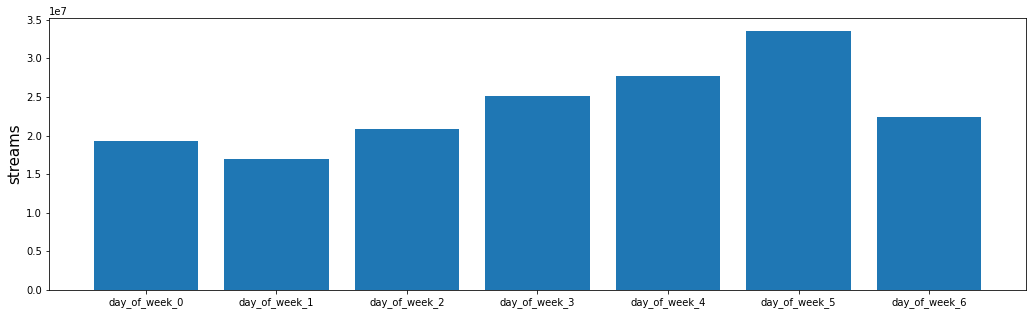

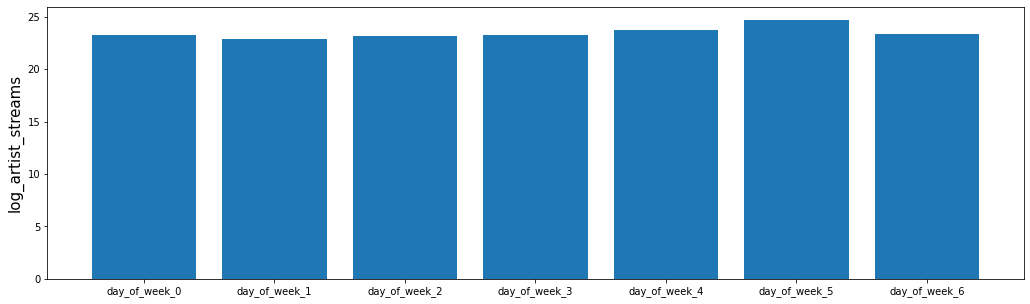

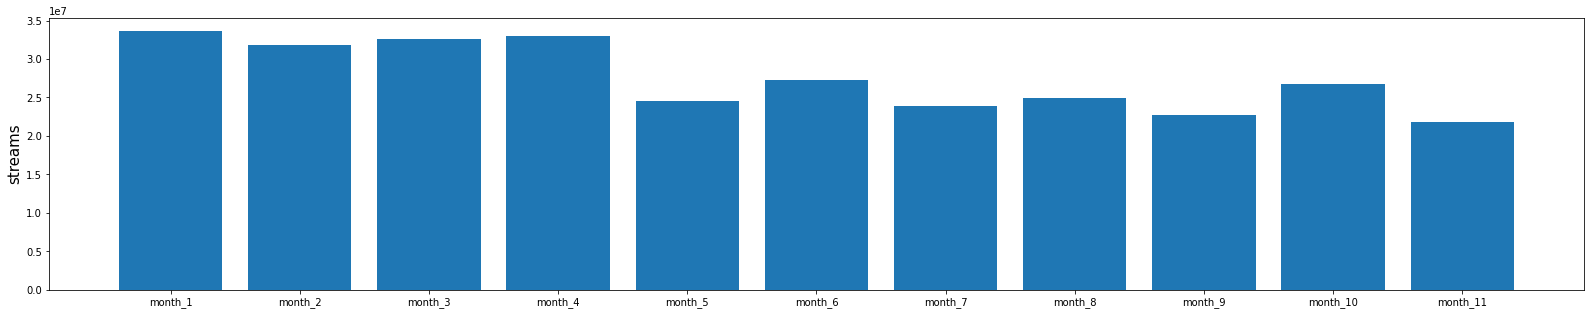

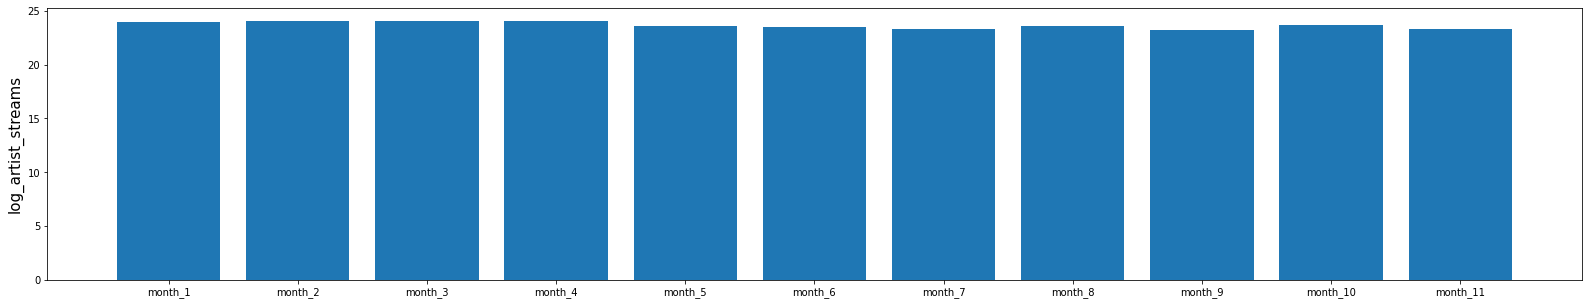

In [13]:
# # takes in a list of column names, representing one-hot encodings (like day_of_week_1, 2, etc...)
def visualize_bar_charts(encodings, target_feature="log_artist_streams"):
    encoding_average_map = {}
    for encoding in encodings:
        average_target_feature = original_df.query(f'{encoding} == 1')[target_feature].mean()
        encoding_average_map[encoding] = average_target_feature
        
    
    labels = list(encoding_average_map.keys())
    values = list(encoding_average_map.values())
    f = plt.figure()
    f.set_figwidth(len(labels) * 2.5)
    f.set_figheight(5)
    plt.bar(range(len(labels)), values, tick_label=labels)
    plt.ylabel(target_feature, fontsize = 15)
    plt.show()

day_of_week_encodings = []
for i in range(0,7):
    day_of_week_encodings.append(f'day_of_week_{i}')

month_encodings = []
for i in range(1, 12):
    month_encodings.append(f'month_{i}')
    
visualize_bar_charts(day_of_week_encodings, "streams")
visualize_bar_charts(day_of_week_encodings, "log_artist_streams")

visualize_bar_charts(month_encodings, "streams")
visualize_bar_charts(month_encodings, "log_artist_streams")

In [14]:
# # takes in a list of column names, representing one-hot encodings (like day_of_week_1, 2, etc...)
def visualize_box_plots(encodings, target_feature="log_artist_streams"):
    data = []
    data_counts = {}
    for encoding in encodings:
        encoding_data = original_df.query(f'{encoding} == 1')[target_feature]
        data_counts[encoding] = len(encoding_data)
        data.append(encoding_data)
        
    fig = plt.figure(figsize =(10, 7))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    plt.show()
    print(data_counts)

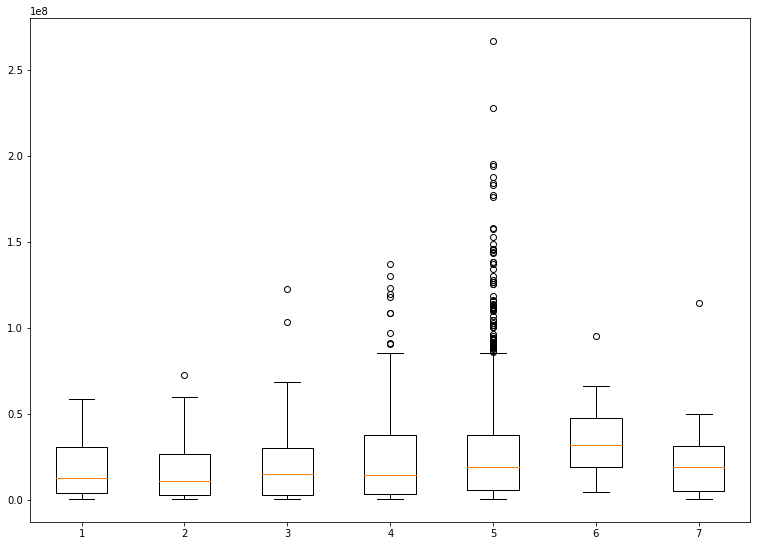

{'day_of_week_0': 42, 'day_of_week_1': 38, 'day_of_week_2': 78, 'day_of_week_3': 255, 'day_of_week_4': 1325, 'day_of_week_5': 29, 'day_of_week_6': 23}


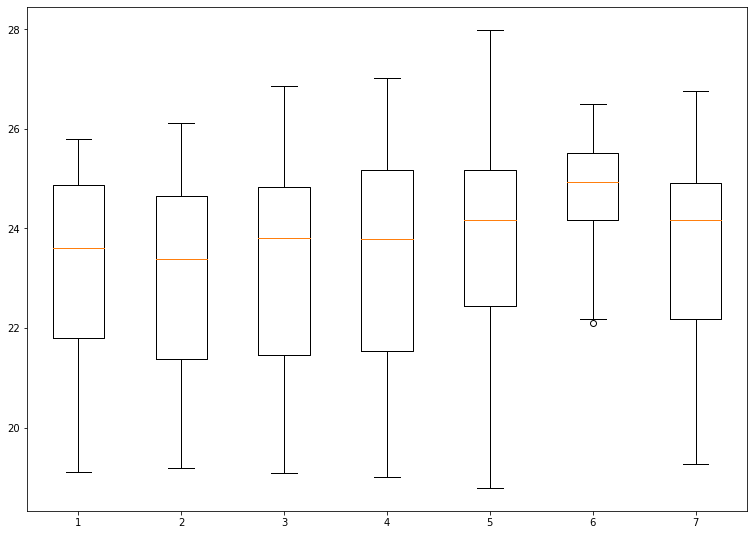

{'day_of_week_0': 42, 'day_of_week_1': 38, 'day_of_week_2': 78, 'day_of_week_3': 255, 'day_of_week_4': 1325, 'day_of_week_5': 29, 'day_of_week_6': 23}


In [15]:
visualize_box_plots(day_of_week_encodings, "streams")
visualize_box_plots(day_of_week_encodings, "log_artist_streams")

In [16]:
def build_regression_model(norm, learning_rate, optimizer_function, layer_sizes=[200,200], add_dropout=False):
    nn_layers = [
        norm # normalization layer
    ]
    for layer_size in layer_sizes:
        nn_layers.append(layers.Dense(layer_size, activation="relu"))
    nn_layers.append(layers.Dense(1))
    
    if add_dropout:
        nn_layers.append(tf.keras.layers.Dropout(rate=0.4))
    
    model = keras.Sequential(
        nn_layers
    )

    model.compile(loss='mean_absolute_error',
                optimizer=optimizer_function(learning_rate))
    return model

In [17]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)
  plt.show()

In [18]:
def test_regression_model(model_name, target_feature, drop_features=[], learning_rate = 0.0001, optimizer = tf.keras.optimizers.Adam, num_epochs=300, layer_config=[200], add_dropout=False):
    # drop the non target feature, so it is not used in the model building.
    dataset = None
    if target_feature == 'streams':
        dataset = top_200_df.drop(['log_artist_streams'], axis=1)
    else:
        dataset = top_200_df.drop(['streams'], axis=1)
        
    dataset = dataset.drop(drop_features, axis=1)
    
    # split into train and test
    train_dataset = dataset.sample(frac=0.8, random_state=0)
    test_dataset = dataset.drop(train_dataset.index)
    
    train_features = train_dataset.copy()
    test_features = test_dataset.copy()

    train_labels = train_features.pop(target_feature)
    test_labels = test_features.pop(target_feature)
    
    normalizer = tf.keras.layers.Normalization(axis=-1)
    normalizer.adapt(np.array(train_features).astype('float32'))
    
    dnn_model = build_regression_model(normalizer, learning_rate, optimizer, layer_config, add_dropout)
    
    train_features = train_features.astype(float)
    train_labels = train_labels.astype(float)

    test_features = test_features.astype(float)
    test_labels = test_labels.astype(float)
    
    history = dnn_model.fit(
        train_features,
        train_labels,
        validation_split=0.2,
        verbose=0, epochs=num_epochs)
    
    predicted_labels = dnn_model.predict(test_features)
    actual_labels = list(test_labels)
    coefficient_of_dermination = r2_score(actual_labels, predicted_labels)
    mse = mean_squared_error(actual_labels, predicted_labels)
    
    print(f'R^2 value of {coefficient_of_dermination}')
    print(f'MSE value of {mse}')

    # to save in the experiment results
    return dnn_model, history, coefficient_of_dermination, mse

### EXPERIMENT: Hyper parameter tuning

Will create continuous regression models, with "streams" and "log_artist_streams" as the target variables.

Initially, we will experiment with just the optimizer used, as well as the learning_rate, and give them all a generous number of epochs (300)

The models will be judged based on the R^2 value of the test set, using the model

Once a model seems to do well, we will experiment with the number of epochs


In [19]:
test_regression_model('base_model', 'streams', optimizer=tf.keras.optimizers.Adam, learning_rate=0.00008, num_epochs=300, add_dropout=True)

2022-08-03 20:57:42.148829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-08-03 20:57:42.151539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-03 20:57:42.151596: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-03 20:57:42.151631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-08-03 20:57:42.151665: W tensorflow/stream_executor/platform/default/dso_loader.cc:6

12/12 [==============================] - 0s 885us/step
R^2 value of -0.8979170749559198
MSE value of 1538215615292937.0


(<keras.engine.sequential.Sequential at 0x7f2b62e488b0>,
 -0.8979170749559198,
 1538215615292937.0)

In [20]:
# generate the experiments
regression_target_features = ['streams', 'log_artist_streams']
optimizers = [tf.keras.optimizers.Adam, tf.keras.optimizers.Adadelta, tf.keras.optimizers.RMSprop]
learning_rates = [0.1, 0.01, 0.001, 0.0001, 0.00001]
layer_configs = [
    [60],
    [200],
    [60,200],
    [60,200,200]   
]
add_dropout_configs = [True, False]


# to be able to turn them into strings
optimizer_names = {
    tf.keras.optimizers.Adam: "Adam",
    tf.keras.optimizers.Adadelta: "Adadelta",
    tf.keras.optimizers.RMSprop: "RMSprop",
    tf.keras.optimizers.SGD: "SGD",
}

In [21]:
def get_experiment_id(exp_params):
    target_feature, optimizer, learning_rate, layer_config, add_dropout = exp_params['target_feature'], exp_params['optimizer'], exp_params['learning_rate'], exp_params['layer_config'], exp_params['add_dropout']
    optimizer_name = optimizer_names[optimizer]
    return f'feature:{str(target_feature)}___optimizer:{str(optimizer_name)}___learning_rate:{str(learning_rate)}__layer_config:{str(layer_config)}__add_dropout:str({add_dropout})'

In [22]:
experiment_configs = []
for target_feature in regression_target_features:
    for optimizer in optimizers:
        for learning_rate in learning_rates:
            for layer_config in layer_configs:
                for add_dropout_config in add_dropout_configs:
                    experiment_config = {
                        "target_feature": target_feature,
                        "optimizer": optimizer,
                        "learning_rate": learning_rate,
                        "layer_config": layer_config,
                        "add_dropout": add_dropout_config
                    }
                    experiment_configs.append(experiment_config)

In [23]:
# NOTE: this will take a long time.
regression_experiment_results = {}
for experiment_config in experiment_configs:
    experiment_id = get_experiment_id(experiment_config)
    print("-------------------------------------------")
    print(experiment_id)
    model, history, r2, mse = test_regression_model(experiment_id, experiment_config['target_feature'], learning_rate=experiment_config['learning_rate'], optimizer=experiment_config['optimizer'], layer_config=experiment_config['layer_config'], add_dropout=experiment_config['add_dropout'])
    regression_experiment_results[experiment_id] = {
        # initial paramters
        "target_feature": experiment_config['target_feature'],
        "learning_rate": experiment_config['learning_rate'],
        "optimizer": optimizer_names[experiment_config['optimizer']],
        "layer_config": str(experiment_config["layer_config"]),
        "add_dropout": str(experiment_config["add_dropout"]),
        # model results
        "model": model,
        "history": history,
        "r2": r2,
        "mse": mse,
    }

-------------------------------------------
feature:streams___optimizer:Adam___learning_rate:0.1__layer_config:[60]__add_dropout:str(True)
12/12 [==============================] - 0s 843us/step
R^2 value of -0.10819829181922014
MSE value of 898167754435148.1
-------------------------------------------
feature:streams___optimizer:Adam___learning_rate:0.1__layer_config:[60]__add_dropout:str(False)
12/12 [==============================] - 0s 974us/step
R^2 value of 0.1463001973182454
MSE value of 691902920620529.9
-------------------------------------------
feature:streams___optimizer:Adam___learning_rate:0.1__layer_config:[200]__add_dropout:str(True)
12/12 [==============================] - 0s 860us/step
R^2 value of -0.08671611403227497
MSE value of 880756971973461.6
-------------------------------------------
feature:streams___optimizer:Adam___learning_rate:0.1__layer_config:[200]__add_dropout:str(False)
12/12 [==============================] - 0s 988us/step
R^2 value of 0.173253279917

In [24]:
# make a table showing the variuos configurations and their R2 values

In [25]:
dataframe_list_objects = []
for result in regression_experiment_results.values():
    dataframe_list_objects.append({
        "target_feature": result['target_feature'],
        "optimizer": result["optimizer"],
        "learning_rate": result["learning_rate"],
        "r2": result["r2"],
        "mse": result["mse"],
        "layer_config": result["layer_config"],
        "add_dropout": result["add_dropout"]
    })

In [26]:
df = pd.DataFrame(dataframe_list_objects)

In [27]:
df.sort_values(by=['r2'], ascending=False).head(10) # just look at the top 10 for now

,target_feature,optimizer,learning_rate,r2,mse,layer_config,add_dropout
93,streams,RMSprop,0.010,0.184155,6.612227e+14,"[60, 200]",False
83,streams,RMSprop,0.100,0.182063,6.629183e+14,[200],False
13,streams,Adam,0.010,0.180304,6.643436e+14,"[60, 200]",False
55,streams,Adadelta,0.010,0.175707,6.680694e+14,"[60, 200, 200]",False
23,streams,Adam,0.001,0.174369,6.691535e+14,"[60, 200, 200]",False
103,streams,RMSprop,0.001,0.173401,6.699382e+14,"[60, 200, 200]",False
3,streams,Adam,0.100,0.173253,6.700581e+14,[200],False
53,streams,Adadelta,0.010,0.167420,6.747857e+14,"[60, 200]",False
45,streams,Adadelta,0.100,0.166424,6.755929e+14,"[60, 200]",False
63,streams,Adadelta,0.001,0.157084,6.831631e+14,"[60, 200, 200]",False


### Initial analysis of experiment
it seems like in general, the models trying to predict streams did the best.

will take a closer look at:
Adam, with learning rate of 0.01, layer config [60,200]
RMSprop, with learning rate of 0.01, layer config of [60,200]

12/12 [==============================] - 0s 1ms/step
R^2 value of 0.18546068571356722
MSE value of 660164297502035.1


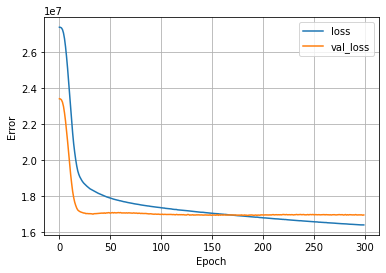

In [28]:
dnn_model, history, coefficient_of_dermination, mse = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.01, optimizer = tf.keras.optimizers.Adam, num_epochs=300, layer_config=[60,200])
plot_loss(history)

12/12 [==============================] - 0s 1ms/step
R^2 value of 0.17516151978917394
MSE value of 668511520917875.1


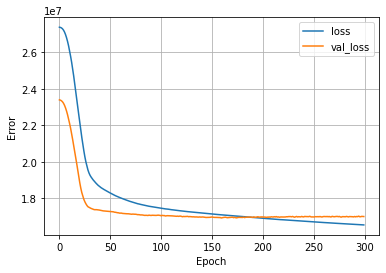

In [29]:
dnn_model, history, coefficient_of_dermination, mse = test_regression_model("RMSprop", target_feature="streams", learning_rate = 0.01, optimizer = tf.keras.optimizers.RMSprop, num_epochs=300, layer_config=[60,200])
plot_loss(history)

#### Will proceed with the Adam model, with approx learning rate of 0.01, and layer sizes of [60,200]
will see if further fine tuning of the hyper parameters leads to better performance

12/12 [==============================] - 0s 986us/step
R^2 value of 0.17366261158596452
MSE value of 669726349550006.5


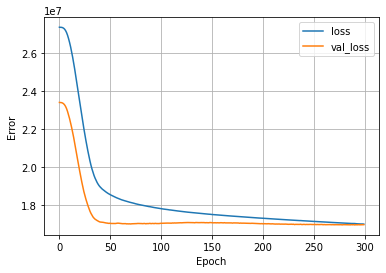

In [30]:
# seems like the learning rate can be decreased a bit, to make the loss drop smoother.
dnn_model, history, coefficient_of_dermination, mse = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.005, optimizer = tf.keras.optimizers.Adam, num_epochs=300, layer_config=[60,200])
plot_loss(history)

12/12 [==============================] - 0s 1ms/step
R^2 value of 0.1443482047088256
MSE value of 693484963140915.4


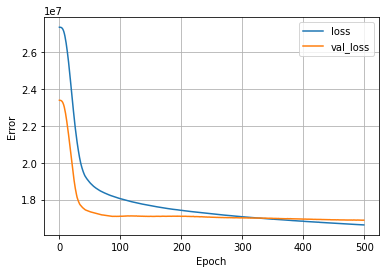

In [31]:
# drop total follower count, model does less well
dnn_model, history, coefficient_of_dermination, mse  = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.005, optimizer = tf.keras.optimizers.Adam, num_epochs=500, drop_features=['total_follower_count'], layer_config=[60,200])
plot_loss(history)

12/12 [==============================] - 0s 1ms/step
R^2 value of 0.199055782358056
MSE value of 649145802423447.5


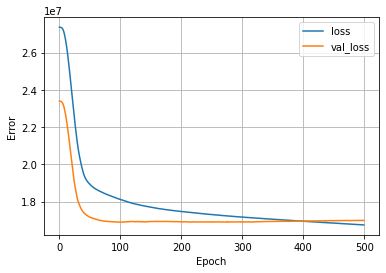

In [32]:
# drop the log total follower count, model seems to do even better
dnn_model, history, coefficient_of_dermination, mse  = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.005, optimizer = tf.keras.optimizers.Adam, num_epochs=500, drop_features=['log_total_follower_count'], layer_config=[60,200])
plot_loss(history)

12/12 [==============================] - 0s 1ms/step
R^2 value of -0.03603841786423212
MSE value of 839683932154498.5


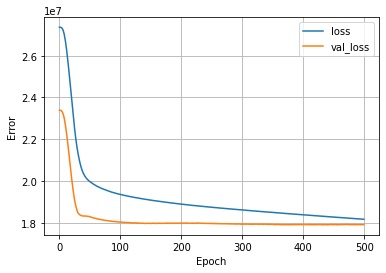

In [33]:
# drop both, lose all predictive power
dnn_model, history, coefficient_of_dermination, mse  = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.005, optimizer = tf.keras.optimizers.Adam, num_epochs=500, drop_features=['total_follower_count','log_total_follower_count'], layer_config=[60,200])
plot_loss(history)

### Best model plot


12/12 [==============================] - 0s 1ms/step
R^2 value of 0.1981710014997209
MSE value of 649862895783511.6


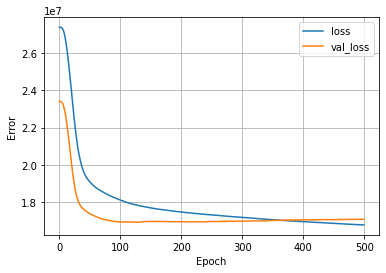

In [34]:
# drop the log total follower count, model seems to do even better. R2 of almost 0.2
dnn_model, history, coefficient_of_dermination, mse  = test_regression_model("Adam_1", target_feature="streams", learning_rate = 0.005, optimizer = tf.keras.optimizers.Adam, num_epochs=500, drop_features=['log_total_follower_count'], layer_config=[60,200])
plot_loss(history)

In [35]:
result_df = top_200_df.copy()
result_df = result_df.drop(['log_artist_streams', 'log_total_follower_count'], axis=1)

In [36]:
result_df_features = result_df.copy()
result_df_labels = result_df_features.pop('streams')

In [37]:
predictions = dnn_model.predict(result_df_features)

56/56 [==============================] - 0s 742us/step


In [38]:
# re-add the labels
result_df['predicted_streams'] = predictions

In [39]:
result_df.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'total_follower_count', 'streams', 'year', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'predicted_streams'],
      dtype='object')

In [40]:
total_follower_counts = result_df['total_follower_count']
stream_counts = result_df['streams']
predicted_stream_counts = result_df['predicted_streams']

Text(0, 0.5, 'Stream Count')

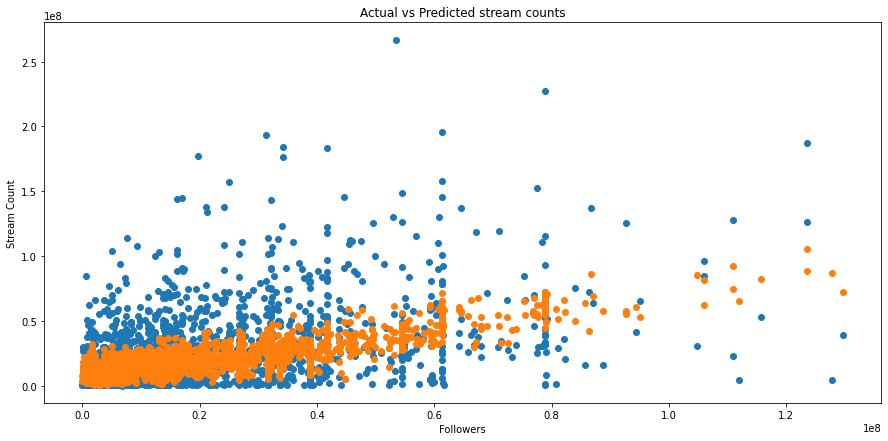

In [41]:
fig = plt.figure(figsize=(15, 7))
plt.scatter(total_follower_counts, stream_counts, label="Actual stream counts")
plt.scatter(total_follower_counts, predicted_stream_counts, label="Predicted stream counts")
plt.title("Actual vs Predicted stream counts")
plt.xlabel('Followers')
plt.ylabel('Stream Count')